In [1]:
# ensure word wrapping fomatting for textual output
# inside noteboot
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
# install necessary packages
!pip install requests_cache
!pip install lime
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import standard libraries
import io
import zipfile
import requests as rq
import requests_cache as rqc
import numpy as np
import pandas as pd

# import text processing tools
import spacy
from nltk.stem import SnowballStemmer
import re

# import persistence support
from joblib import dump, load

# import support for sklearn transformers 
# and pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

# import visualization tools
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.palettes import color_palette

# import lime text explainer
from lime.lime_text import LimeTextExplainer

# IPython support
from IPython.display import display, HTML

In [4]:
# enforce at least version 3.5.2 of the matplotlib
if (mplt.__version__ < '3.5.2'):
  print("Invalid version of matplotlib detected (at least 3.5.2 required). \n")
  print("**** RUNTIME HAS BEEN FORCEFULLY STOPPED **** \n")
  raise Exception("PLEASE RESTART THE RUNTIME")

In [5]:
# ensure reproducible results
rand_state = 1234

# Load Previously Trained Classifiers

We will preload the previously trained classifiers in order to ensure explainability information.

First of all we wil re-define the tokenization transformer to be used in the preloaded classifiers.

In [6]:
class TokenizationTransformer (BaseEstimator, TransformerMixin) :
  """
  Transformer that ensures processing of input text, mostly:

  * Tokenization and stemming of input text
  * Removal of superfluous information such as punctuation
    or stop words 
  """

  def __init__(self, nlp_support, custom_stop_words_tokens) :
    """
    Parameters
    ----------
      nlp_support : Object
          NLP support (usually based on Spacy)
      custom_stop_words_tokens : [str]
          A collection of custom tokens
    """
    super().__init__()
    self.nlp_support = nlp_support;
    self.covid_19_regexp = r"-19";    
    self.covid_regexp = r"covid";
    self.number_regexp = r"[0-9]+";
    self.stemmer = SnowballStemmer("english");
    self.custom_stop_words_tokens = custom_stop_words_tokens;


  def is_valid(self, token) :
    """
    Checks if a token is valid
    Parameters
    ----------
      token : str
          The token checked for validity

    Returns
    -------
    bool
        TRUE if the token is valid, otherwise FALSE          
    """
    # remove tokens based on their syntatic information 
    is_invalid = token.is_stop or \
      token.is_punct or \
      token.is_left_punct or \
      token.is_right_punct or \
      token.is_space or \
      token.is_bracket or \
      token.is_quote or \
      token.is_currency or \
      token.like_url or \
      token.like_num or \
      token.like_email;

    return not is_invalid;

  def prepare(self, text) :
    """
    Prepares a token for machine learning processing
    Parameters
    ----------
      text : str
          The token's text to be prepared, performing validation as well

    Returns
    -------
    str
        The prepared text, None if token is invalid          
    """    
    prepared_text = text.strip();  
    prepared_text = prepared_text.lower();
    prepared_text = re.sub(self.covid_19_regexp, "", prepared_text);
    prepared_text = re.sub(self.number_regexp, "", prepared_text);
    prepared_text = self.stemmer.stem(prepared_text);
    
    if (len(prepared_text) == 0) :
      return None;

    if (prepared_text in self.custom_stop_words_tokens):
      return None;  

    return prepared_text;

  def fit(self, X, Y=None) :
    return self;

  def transform(self, X, Y = None) :
    
    data_size = 0
    
    if (type(X) == np.ndarray) :
      data_size = X.shape[0]
    else:  
      data_size = len(X)

    tokens_text_processed_joined = np.repeat(None, data_size);

    for i in range(0, data_size) :
      tokens = self.nlp_support(X[i]);
      tokens_text = [];
      tokens_text_lemma = [];
      tokens_text_pos = [];
      tokens_text_processed = [];

      for token in tokens:
        if (self.is_valid(token)) :
          prepared_text = self.prepare(token.text); 
          if (prepared_text == None) :
            continue;
          tokens_text_processed = np.append(tokens_text_processed, prepared_text);

      tokens_text_processed_joined[i] = " ".join(tokens_text_processed);

    return tokens_text_processed_joined;

    def fit_transform(self, X, Y = None) :
      return self.fit(X, Y).transform(X, Y)

In [7]:
def get_remote_zip_file(archive_url, file_name) :
  """
  Retrieves an archive file from an URL and extracts the content of an inside file 
  Parameters
  ----------
    archive_url : str
        The url for retrieving the archive
    file_name : str
        The filename holding the content

  Returns
  -------
  file
      The opened file           
  """  

  response = rqc.CachedSession().get(archive_url)
  binary_data = io.BytesIO(response.content)

  with zipfile.ZipFile(binary_data) as z:
   return z.open(file_name)


In [8]:
# load the classifier from the remote URL
MODEL_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Detection-TFIDF/raw/main/model/COVID_fake_news_TFIF_SVC_pipeline.zip"
MODEL_FILE = "COVID_fake_news_TFIF_SVC_pipeline.joblib"

loaded_classifier_pipeline = None

with get_remote_zip_file(MODEL_URL, MODEL_FILE) as f:
  loaded_classifier_pipeline = load(f)


# Load the Test Data

We will load the dataset saved along with the classifier and extract the test related data.

In [9]:
# load the classifier from the remote URL
DATASETS_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Detection-TFIDF/raw/main/data/processed/datasets.zip"
DATASETS_FILE = "datasets.npz"

X_test = None
Y_test = None

with get_remote_zip_file(DATASETS_URL, DATASETS_FILE) as f_datasets:
  loaded_data = np.load(f_datasets, allow_pickle=True)
  X_test = loaded_data["X_test"]
  Y_test = loaded_data["Y_test"]

# Identify Prediction Highlights

We need to explore the predicted results and understand better the nature of the predicted results.

We will use the classifier to predict probabilities and inspect the most representative samples of true positives/negatives and false positives/negatives.

In [10]:
# use classifier to predict probabilities
Y_pred_proba = loaded_classifier_pipeline.predict_proba(X_test)

In [11]:
# determine the most representative true positive fit
# i.e. true positive correctly classified with the highest probability
index_most_representative_true_positive_fit = np.argmax(Y_pred_proba[:,1]*Y_test)
probability_most_representative_true_positive_fit = Y_pred_proba[index_most_representative_true_positive_fit,1]
most_representative_true_positive_fit = X_test[index_most_representative_true_positive_fit]

print(f"Most representative true positive fit predicted with the probability of \
{probability_most_representative_true_positive_fit:.2%} as fake news is: \n\n {most_representative_true_positive_fit}")

Most representative true positive fit predicted with the probability of 99.10% as fake news is: 

 Coronavirus: US President Donald Trump suggests 'injecting disinfectant' to treat COVID-19, 'clean the lungs' Donald Trump suggests injecting disinfectant could be an effective treatment for COVID-19. Credits: Video - The White House; Image - Reuters
Being injected with disinfectant could be an effective treatment for COVID-19, US President Donald Trump has bizarrely claimed during a disastrous press conference from the White House.
Trump made the comment after Department of Homeland Security (DHS) official Bill Bryan gave a presentation on research his team has carried out, which showed the coronavirus does not live as long in humidity or warmer temperatures.
After Bryan explained that the virus dies quickest in sunlight, Trump suggested there may be some way to "[bring] the light inside the body".
Related News
Trump says he's signing order to 'suspend' US immigration
China 'must have th

In [12]:
# determine the most representative true negative fit
# i.e. true negative correctly classified with the highest probability
index_most_representative_true_negative_fit = np.argmax(Y_pred_proba[:,0]*(1 - Y_test))
probability_most_representative_true_negative_fit = Y_pred_proba[index_most_representative_true_negative_fit,1]   
most_representative_true_negative_fit = X_test[index_most_representative_true_negative_fit]

print(f"Most representative true negative fit predicted with the probability of \
{probability_most_representative_true_negative_fit:.2%} as fake news is: \n\n {most_representative_true_negative_fit}")

Most representative true negative fit predicted with the probability of 0.20% as fake news is: 

 Public Health Advisory To Nigerians On Novel Corona Virus This is a public health advisory on a new virus; the novel coronavirus (nCoV), by the Nigeria Centre for Disease Control. As this is a new virus, and new information is emerging every day, this advisory will be updated as new information and research on the virus and its impact on populations become available.The first case of a novel (new) coronavirus (2019nCoV) strain was confirmed in China on the 7th of January 2020. According to preliminary investigations, most patients either visited or worked in the Huanan Seafood wholesale market, Wuhan city. As at the 20th of January 2020, 278 laboratory-confirmed cases of 2019-nCoV infection including six deaths have been reported to WHO globally since the first case was reported on the 31st of December 2019.Many of the initial cases were thought to have contacted the virus through animal-t

In [13]:
# determine the most representative false positive fit
# i.e. false positive incorrectly classified with the highest probability
index_most_representative_false_positive_fit = np.argmax(Y_pred_proba[:,1]*(1 - Y_test))
probability_most_representative_false_positive_fit = Y_pred_proba[index_most_representative_false_positive_fit, 1]   
most_representative_false_positive_fit = X_test[index_most_representative_false_positive_fit]

print(f"Most representative false positive fit predicted with the probability of \
{probability_most_representative_false_positive_fit:.2%} as fake news is: \n\n {most_representative_false_positive_fit}")

Most representative false positive fit predicted with the probability of 98.20% as fake news is: 

 Mississippi man recovering at home after 21 days on a ventilator due to COVID-19 A Pearl River County man is recovering at home after spending three weeks on a ventilator due to COVID-19. Doctors didn’t believe there was much chance for survival, but the man and his family never gave up hope.
After 21 days on a ventilator, Joey Collum was wheeled out of a Hattiesburg hospital.
“Lord. I don’t even know how to put that into words,” Collum said. “I knew then I was way more blessed than I ever thought I was.”
Emergency responders escorted Collum and his wife Datia from the hospital to their church where a welcome committee awaited.
“They had their sirens going down the highway and he was just crying. He was just crying. Because he made it. He made it,” Datia said.
Datia says, according to doctors, the odds were against him. The 62-year-old Mississippi man has pre-existing conditions and hadn

In [14]:
# determine the most representative false negative fit
# i.e. false negative incorrectly classified with the highest probability
index_most_representative_false_negative_fit = np.argmax(Y_pred_proba[:,0]*Y_test)
probability_most_representative_false_negative_fit = Y_pred_proba[index_most_representative_false_negative_fit, 1]   
most_representative_false_negative_fit = X_test[index_most_representative_false_negative_fit]

print(f"Most representative false negative fit predicted with the probability of \
{probability_most_representative_false_negative_fit:.2%} as fake news is: \n\n {most_representative_false_negative_fit}")

Most representative false negative fit predicted with the probability of 1.75% as fake news is: 

 Govt reviews preparedness at highest level to manage Corona Virus in country A Group of Ministers met in New Delhi yesterday to review the preparedness and steps taken by the Ministries of Health, Shipping, External Affairs, Civil Aviation and Home Affairs regarding management of Novel Coronavirus in the country. The meeting was chaired by the Health Minister Dr Harsh Vardhan. The group, which has been constituted on the directions of Prime Minister Narendra Modi, comprises of Health Minister Dr. Harsh Vardhan, Civil Aviation Minister Hardeep Puri, External Affairs Minister S Jaishankar, Minister of State for Home G Kishan Reddy, Minister of State for Health Ashwini Kumar Choubey and Shipping Minister Mansukh Lal Mandaviya. A presentation of the status of the NCOV-2019 was made to the GoM. The members were also apprised of the three cases reported from Kerala, one of which was confirmed y

In [15]:
# determine the item that is closest to the decision boundary
# i.e. closest to 50% probability to be a fake news
index_most_representative_closest_to_decision_boundary = np.argmax(-abs(Y_pred_proba[:, 0] - Y_pred_proba[:, 1]))
probability_most_representative_closest_to_decision_boundary = Y_pred_proba[index_most_representative_closest_to_decision_boundary, 1]   
most_representative_closest_to_decision_boundary = X_test[index_most_representative_closest_to_decision_boundary]

print(f"The item closest to the decision boundary predicted with the probability of \
{probability_most_representative_closest_to_decision_boundary:.2%} as fake news is: \n\n {most_representative_closest_to_decision_boundary}")

The item closest to the decision boundary predicted with the probability of 50.00% as fake news is: 

 Singapore races to build beds for COVID-19 patients as cases surge Singapore is rapidly building bed space for coronavirus patients in cavernous exhibition halls and other temporary facilities as it faces a surge in cases, mainly among its large community of low-paid migrant workers.
One such facility at Changi Exhibition Center – home to the Singapore Airshow, Asia’s biggest aerospace gathering – could eventually house over 4,000 patients recovering from the disease and those with mild symptoms.
“The entire process of setting up the infrastructure took six days,” Joseph Tan, a member of the organizing committee for the temporary facility, told Reuters on a visit.
The tiny city-state of 5.7 million people registered 931 new coronavirus infections, its health ministry said on Sunday, taking the total number of COVID-19 cases to 13,624. The number of new cases rose from 618 reported on 

At this point we have identified the relevant samples of predictions, still we need to understand why the classifier is generating these results.

In other words we need to reach a certain degree of explainability for our models.

# Local Explainability

We will be treating the classifier as a black box classifier. This is even more appropriate since the classifier we used is a SVM-based classifier, these classifiers have a low degree of explainability.

For starters we will focus on local explainability, more specific we will focus on understanding which features (in our case words/tokens) contribute the most towards a certain classification. For this reason we will use the [LIME](https://github.com/marcotcr/lime) package which offers model agnostic local intepretability.

In [16]:
# prepare the explainer for the binary classification
# using Veridic and Fake news
lime_explainer = LimeTextExplainer(
    class_names = ["Veridic News", "Fake News"], 
    random_state= rand_state
  )

In [17]:


def display_explanation_factors(explanation, title, probability) :
  """
  Displays the explanation factors and their impact towards a veridic or 
  a fake story. 
  Parameters
  ----------
    explanation : Explanation
        The explanation object
    title : str
        The displayed title
    probability:
        The predicted probability for a fake news    

  Returns
  -------
    None
  """  
  list_expl = explanation.as_list()
  labels, values = zip(*list_expl)

  x_data = np.round(np.array(values), 3)
  y_data = np.array(labels) 

  fig, ax = plt.subplots()
  plt.subplots_adjust(left=-1, right = 0)
  ax.xaxis.set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.margins(x=0.2)

  color_mapper = lambda t: "darkred" if t > 0 else "darkgreen"
  chart = sns.barplot(
      x = x_data, 
      y = y_data,
      palette = np.vectorize(color_mapper)(x_data)
    )
  chart.bar_label(chart.containers[0])

  chart.set_title(title + "\n" + "Fake News Probability: " +  str(probability))
  plt.show()

In [18]:
def generate_explanation_text_HTML(explanation, text) :
  """
  Generates the adnotated text (red for fake news, green for veridic news) in regards
  to the explanation and the text explained. 
  Parameters
  ----------
    explanation : Explanation
        The explanation object
    text : str
        The original text

  Returns
  -------
    str
      The generated adnotated text (HTML format)
  """   
  expl_list = explanation.as_list()
  tokens = list(zip(*expl_list))[0]
  tokens_impact = list(zip(*expl_list))[1]

  tokens_impact_arr_abs = np.abs(np.array(tokens_impact))
  tokens_impact_arr_abs_max = np.max(tokens_impact_arr_abs)
  tokens_impact_arr_abs_ratio = tokens_impact_arr_abs / (tokens_impact_arr_abs_max)

  replaced = text

  for i in range(len(tokens)) :

    color = f"rgba(256,0,0,{tokens_impact_arr_abs_ratio[i]})" if tokens_impact[i] > 0  \
            else f"rgba(0,256,0,{tokens_impact_arr_abs_ratio[i]})"

    format_string = f"<span style = 'background-color:{color}'>{tokens[i]}</span>"
    replaced = re.sub(tokens[i], format_string, replaced)

  replaced = f"<div>{replaced}</div>"

  return replaced

def print_explanation_text_HTML(explanation, text) :
  """
  Prints the adnotated text (red for fake news, green for veridic news) in regards
  to the explanation and the text explained. 
  Parameters
  ----------
    explanation : Explanation
        The explanation object
    text : str
        The original text

  Returns
  -------
    None
  """  
  generated_HTML = generate_explanation_text_HTML(explanation, text)
  display(HTML(generated_HTML))

We will use the text explainer to ensure that we are able to explain various higlight predictions identified before.

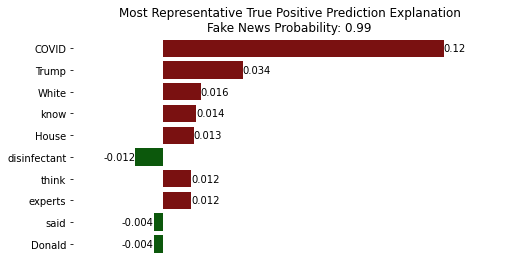

In [19]:
# explain the most representative true positive fit 
# predicted by the model
most_representative_true_positive_fit_explanation = lime_explainer.explain_instance(
    most_representative_true_positive_fit,
    loaded_classifier_pipeline.predict_proba
  )

display_explanation_factors(
    most_representative_true_positive_fit_explanation,
    "Most Representative True Positive Prediction Explanation",
    round(probability_most_representative_true_positive_fit, 2)
  )

print_explanation_text_HTML(
    most_representative_true_positive_fit_explanation,
    most_representative_true_positive_fit
  )

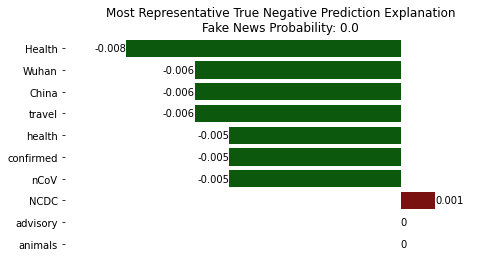

In [20]:
# explain the most representative true negative fit 
# predicted by the model
most_representative_true_negative_fit_explanation = lime_explainer.explain_instance(
    most_representative_true_negative_fit,
    loaded_classifier_pipeline.predict_proba
  )

display_explanation_factors(
    most_representative_true_negative_fit_explanation,
    "Most Representative True Negative Prediction Explanation",
    round(probability_most_representative_true_negative_fit, 2)
  )

print_explanation_text_HTML(
    most_representative_true_negative_fit_explanation,
    most_representative_true_negative_fit
  )

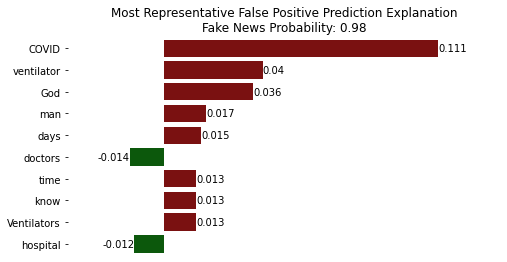

In [21]:
# explain the most representative false positive fit 
# predicted by the model
most_representative_false_positive_fit_explanation = lime_explainer.explain_instance(
    most_representative_false_positive_fit,
    loaded_classifier_pipeline.predict_proba
  )

display_explanation_factors(
    most_representative_false_positive_fit_explanation,
    "Most Representative False Positive Prediction Explanation",
    round(probability_most_representative_false_positive_fit, 2)
  )

print_explanation_text_HTML(
    most_representative_false_positive_fit_explanation,
    most_representative_false_positive_fit
  )

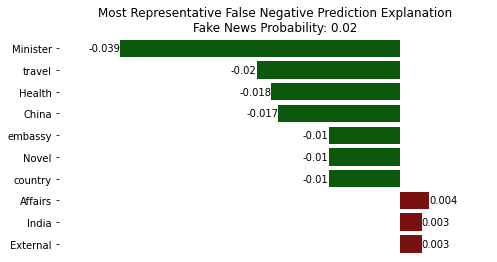

In [22]:
# explain the most representative false negative fit 
# predicted by the model
most_representative_false_negative_fit_explanation = lime_explainer.explain_instance(
    most_representative_false_negative_fit,
    loaded_classifier_pipeline.predict_proba
  )

display_explanation_factors(
    most_representative_false_negative_fit_explanation,
    "Most Representative False Negative Prediction Explanation",
    round(probability_most_representative_false_negative_fit, 2)
  )

print_explanation_text_HTML(
    most_representative_false_negative_fit_explanation,
    most_representative_false_negative_fit
  )

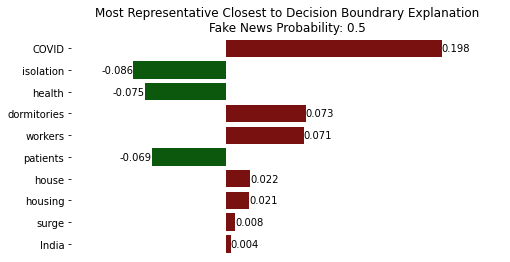

In [23]:
# explain the most representative closest to decision boundary 
# predicted by the model
most_representative_closest_to_decision_boundary_explanation = lime_explainer.explain_instance(
    most_representative_closest_to_decision_boundary,
    loaded_classifier_pipeline.predict_proba
  )

display_explanation_factors(
    most_representative_closest_to_decision_boundary_explanation,
    "Most Representative Closest to Decision Boundrary Explanation",
    round(probability_most_representative_closest_to_decision_boundary, 2)
  )

print_explanation_text_HTML(
    most_representative_closest_to_decision_boundary_explanation,
    most_representative_closest_to_decision_boundary
  )